<h1 style="text-align: center; font-size: 2.3em; color: navy; font-family: Arial, sans-serif; font-weight: bold;">
Astrophysical Techniques – Homework 1 
</h1>

<h2 style="text-align: center; font-size: 2em; color: black; font-family: Arial, sans-serif;">
Estimation the Effect of Atmospheric Extinction
</h2>

<p style="text-align: center; font-size: 1.2em; font-family: Georgia, serif;">
Master in Astrophysics and Space Science (MASS)-(2024/2025) <br>
Department of Astronomy, University of Belgrade <br>
Instructor: Prof. Dragana Ilić
</p>

<p style="text-align: center; font-size: 1.2em; font-family: Georgia, serif; font-style: italic;">
Report by Nandita Das
</p>

## **Introduction**

Ground-based astronomical observations are fundamentally affected by the Earth's atmosphere. As electromagnetic radiation from celestial sources traverses the atmosphere, it undergoes scattering and absorption due to interactions with air molecules, aerosols, and water vapor. These processes reduce the apparent brightness of stars and other objects and introduce wavelength-dependent effects that must be corrected for in any precise photometric analysis. This phenomenon, known as **atmospheric extinction**, is one of the major sources of systematic error in optical astronomy.

Atmospheric extinction is most significant at low altitudes (i.e., high zenith angles), where the light must travel through a thicker column of atmosphere. The total attenuation depends not only on the intrinsic transparency of the atmosphere on a given night, but also on the **airmass**, which quantifies the optical path length relative to the zenith. Airmass increases with decreasing altitude and is approximately equal to 1 when a source is overhead.

To correct for this extinction and calibrate observed magnitudes, astronomers rely on **standard stars** — stars with well-established magnitudes in standard photometric systems, such as the Johnson–Cousins UBVRI system. By observing these stars at various altitudes and determining how their observed brightness changes with airmass, we can derive the **extinction coefficient** $k$, which describes the magnitude loss per unit airmass. This relationship follows the **Beer–Lambert law**, which in logarithmic form becomes:

$$
m_\text{inst} = m_0 + k \cdot X
$$

Where:

- $m_\text{inst}$ is the instrumental magnitude recorded at the telescope  
- $m_0$ is the magnitude the star would have above the atmosphere  
- $k$ is the extinction coefficient  
- $X$ is the airmass

This experiment is designed to measure the extinction coefficient $k_V$ in the Johnson V band. Observations of multiple standard stars were performed at various local sidereal times (LSTs), allowing each star to be observed at different altitudes and thus different airmasses. The instrumental magnitudes were calculated from photon counts recorded through V and B filters. Using coordinate transformations and airmass approximations based on the observer’s location and observing time, the airmass for each observation was computed. By performing linear regression between magnitude and airmass, the extinction coefficient $k_V$ was estimated.

Furthermore, we examined the color transformation between instrumental and standard magnitudes. Instrumental magnitudes are inherently affected by system response and atmospheric transparency, and are not directly comparable across different observing nights or instruments. To correct this, we established a linear transformation between the instrumental color index $(b - v)$ and the standard color index $(B - V)$, as well as a relationship between the instrumental V magnitude and the standard V magnitude.

Finally, we used these transformations to calibrate the magnitude of a previously uncharacterized target star. The procedures in this report thus illustrate the fundamental role of atmospheric extinction correction in modern photometry and demonstrate the methods required to convert raw observational data into calibrated, science-ready measurements.

## **Import Libraries**

In [1]:
# import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from astroquery.simbad import Simbad
from astropy.coordinates import SkyCoord, EarthLocation, AltAz
from astropy import units as u
from astropy.time import Time
from astropy.coordinates import Angle 
from scipy.optimize import curve_fit

In [2]:
### Let's write down our data

# List of star names, each repeated 4 times (one for each observation)
stars = ['HR7235', 'HR7235', 'HR7235', 'HR7235', 
        'HR7298', 'HR7298', 'HR7298', 'HR7298', 
        'HR7377', 'HR7377', 'HR7377', 'HR7377', 
        'HR7387', 'HR7387', 'HR7387', 'HR7387',
        'HR7405', 'HR7405', 'HR7405', 'HR7405', 
        'HR7478', 'HR7478', 'HR7478', 'HR7478']

# Measured photon counts in the V filter for each observation
N_Vs = [1.49e7, 1.42e7, 1.32e7, 1.05e7,
        4.65e6, 4.33e6, 3.21e6, 3.61e6,
        1.04e7, 9.60e6, 8.33e6, 6.91e6,
        3.24e6, 2.82e6, 2.38e6, 1.91e6,
        3.92e6, 3.81e6, 3.45e6, 2.56e6,
        3.12e6, 3.12e6, 2.96e6, 2.38e6]

# Measured photon counts in the B filter for each observation
N_Bs = [4.90e7, 4.37e7, 4.03e7, 2.74e7,
        1.94e7, 1.79e7, 1.11e7, 1.24e7,
        2.82e7, 2.40e7, 1.97e7, 1.45e7,
        7.42e6, 5.67e6, 4.53e6, 3.01e6,
        4.37e6, 4.17e6, 3.58e6, 2.23e6,
        5.47e6, 5.52e6, 4.96e6, 3.42e6]

# Local Sidereal Time (LST) at which each observation was made
LSTs = ['19 29.6', '22 18.6', '23 10.2', '00 09.4',
        '19 32.8', '22 22.0', '23 13.6', '01 15.2',
        '19 36.0', '22 25.6', '23 17.1', '00 02.1',
        '19 39.5', '22 29.1', '23 21.0', '00 05.9',
        '19 43.1', '22 32.8', '23 24.4', '01 19.0',
        '19 46.9', '22 36.7', '23 28.7', '01 23.1']

# Create the initial DataFrame
df = pd.DataFrame({'star': stars, 'N_V': N_Vs, 'N_B': N_Bs, 'LST': LSTs})

# Display the first few rows
df

,star,N_V,N_B,LST
0,HR7235,14900000.0,49000000.0,19 29.6
1,HR7235,14200000.0,43700000.0,22 18.6
2,HR7235,13200000.0,40300000.0,23 10.2
3,HR7235,10500000.0,27400000.0,00 09.4
4,HR7298,4650000.0,19400000.0,19 32.8
5,HR7298,4330000.0,17900000.0,22 22.0
6,HR7298,3210000.0,11100000.0,23 13.6
7,HR7298,3610000.0,12400000.0,01 15.2
8,HR7377,10400000.0,28200000.0,19 36.0
9,HR7377,9600000.0,24000000.0,22 25.6


In [3]:
# Create a Simbad query object
simbad = Simbad()  

# Add B and V magnitudes to the query result using VOTable fields
simbad.add_votable_fields("flux(B)", "flux(V)")

/var/folders/zm/gqp_q1cx5ql75g30zx8blmv00000gn/T/ipykernel_85583/2381780105.py:5: DeprecationWarning: The notation 'flux(V)' is deprecated since 0.4.8 in favor of 'V'. You will see the column appearing with its new name in the output. See section on filters in https://astroquery.readthedocs.io/en/latest/simbad/simbad_evolution.html to see the new ways to interact with SIMBAD's fluxes.
  simbad.add_votable_fields("flux(B)", "flux(V)")
/var/folders/zm/gqp_q1cx5ql75g30zx8blmv00000gn/T/ipykernel_85583/2381780105.py:5: DeprecationWarning: The notation 'flux(B)' is deprecated since 0.4.8 in favor of 'B'. You will see the column appearing with its new name in the output. See section on filters in https://astroquery.readthedocs.io/en/latest/simbad/simbad_evolution.html to see the new ways to interact with SIMBAD's fluxes.
  simbad.add_votable_fields("flux(B)", "flux(V)")


In [4]:
# Query SIMBAD for each star in the DataFrame and store the result tables in a list
simbad_tables = [simbad.query_object(star) for star in df['star']]

In [5]:
# Extract RA, DEC, B, and V magnitudes from each SIMBAD result table
RAs, DECs, Vs, Bs = [], [], [], []

for star_table in simbad_tables:
    RA_HA = star_table['ra'][0]     # Right Ascension in HMS string format
    DEC_DMS = star_table['dec'][0]  # Declination in DMS string format
    V = star_table['V'][0]          # V magnitude
    B = star_table['B'][0]          # B magnitude

    RAs.append(RA_HA)
    DECs.append(DEC_DMS)
    Vs.append(V)
    Bs.append(B)

# Add the extracted values as new columns to the DataFrame
df['RA_HA'] = RAs
df['DEC_DMS'] = DECs
df['V'] = Vs
df['B'] = Bs

df

,star,N_V,N_B,LST,RA_HA,DEC_DMS,V,B
0,HR7235,14900000.0,49000000.0,19 29.6,286.352533,13.863477,2.990,3.000
1,HR7235,14200000.0,43700000.0,22 18.6,286.352533,13.863477,2.990,3.000
2,HR7235,13200000.0,40300000.0,23 10.2,286.352533,13.863477,2.990,3.000
3,HR7235,10500000.0,27400000.0,00 09.4,286.352533,13.863477,2.990,3.000
4,HR7298,4650000.0,19400000.0,19 32.8,288.439535,39.145966,4.398,4.243
5,HR7298,4330000.0,17900000.0,22 22.0,288.439535,39.145966,4.398,4.243
6,HR7298,3210000.0,11100000.0,23 13.6,288.439535,39.145966,4.398,4.243
7,HR7298,3610000.0,12400000.0,01 15.2,288.439535,39.145966,4.398,4.243
8,HR7377,10400000.0,28200000.0,19 36.0,291.374589,3.114779,3.360,3.680
9,HR7377,9600000.0,24000000.0,22 25.6,291.374589,3.114779,3.360,3.680


In [6]:
# Convert RA (HMS) and DEC (DMS) string values to decimal degrees
RAs_deg, DECs_deg = [], []

for index, row in df.iterrows():
    ra_HA = row['RA_HA']        # Right Ascension as HMS string (e.g., '19 29.6')
    dec_DMS = row['DEC_DMS']    # Declination as DMS string (e.g., '+45 12 30')
    
    # Use SkyCoord for coordinate conversion
    coord = SkyCoord(ra_HA, dec_DMS, unit=(u.hourangle, u.deg))
    
    # Append converted decimal degree values
    RAs_deg.append(coord.ra.deg)
    DECs_deg.append(coord.dec.deg)

# Store decimal values in the DataFrame
df['ra_DEG'] = RAs_deg
df['dec_DEG'] = DECs_deg

df

,star,N_V,N_B,LST,RA_HA,DEC_DMS,V,B,ra_DEG,dec_DEG
0,HR7235,14900000.0,49000000.0,19 29.6,286.352533,13.863477,2.990,3.000,335.288001,13.863477
1,HR7235,14200000.0,43700000.0,22 18.6,286.352533,13.863477,2.990,3.000,335.288001,13.863477
2,HR7235,13200000.0,40300000.0,23 10.2,286.352533,13.863477,2.990,3.000,335.288001,13.863477
3,HR7235,10500000.0,27400000.0,00 09.4,286.352533,13.863477,2.990,3.000,335.288001,13.863477
4,HR7298,4650000.0,19400000.0,19 32.8,288.439535,39.145966,4.398,4.243,6.593026,39.145966
5,HR7298,4330000.0,17900000.0,22 22.0,288.439535,39.145966,4.398,4.243,6.593026,39.145966
6,HR7298,3210000.0,11100000.0,23 13.6,288.439535,39.145966,4.398,4.243,6.593026,39.145966
7,HR7298,3610000.0,12400000.0,01 15.2,288.439535,39.145966,4.398,4.243,6.593026,39.145966
8,HR7377,10400000.0,28200000.0,19 36.0,291.374589,3.114779,3.360,3.680,50.618837,3.114779
9,HR7377,9600000.0,24000000.0,22 25.6,291.374589,3.114779,3.360,3.680,50.618837,3.114779


In [7]:
# Define Toronto observatory latitude in degrees and convert to radians
observatory_lat_deg = 43 + (52 / 60)  # 43 degrees 52 minutes
observatory_lat_rad = np.radians(observatory_lat_deg)

# Function to calculate cos(Z) based on LST, RA, and DEC
def calculate_cos_Z(LST_HA, RA_deg, DEC_deg):
    # Convert LST string (e.g., "10 30") to degrees
    LST_deg = Angle(LST_HA, unit=u.hourangle).degree
    hour_angle_deg = LST_deg - RA_deg
    hour_angle_rad = np.radians(hour_angle_deg)
    DEC_rad = np.radians(DEC_deg)

    # cos(Z) formula: projection of the star altitude angle
    cos_Z = np.sin(observatory_lat_rad) * np.sin(DEC_rad) + \
            np.cos(observatory_lat_rad) * np.cos(DEC_rad) * np.cos(hour_angle_rad)
    return cos_Z

# Calculate cos(Z) for each star and store in a new column
cos_Zs = []
for index, row in df.iterrows():
    cos_Z = calculate_cos_Z(row['LST'], row['ra_DEG'], row['dec_DEG'])
    cos_Zs.append(cos_Z)

df['cos_Z'] = cos_Zs
df

,star,N_V,N_B,LST,RA_HA,DEC_DMS,V,B,ra_DEG,dec_DEG,cos_Z
0,HR7235,14900000.0,49000000.0,19 29.6,286.352533,13.863477,2.990,3.000,335.288001,13.863477,0.678890
1,HR7235,14200000.0,43700000.0,22 18.6,286.352533,13.863477,2.990,3.000,335.288001,13.863477,0.865954
2,HR7235,13200000.0,40300000.0,23 10.2,286.352533,13.863477,2.990,3.000,335.288001,13.863477,0.850029
3,HR7235,10500000.0,27400000.0,00 09.4,286.352533,13.863477,2.990,3.000,335.288001,13.863477,0.789363
4,HR7298,4650000.0,19400000.0,19 32.8,288.439535,39.145966,4.398,4.243,6.593026,39.145966,0.597281
5,HR7298,4330000.0,17900000.0,22 22.0,288.439535,39.145966,4.398,4.243,6.593026,39.145966,0.916278
6,HR7298,3210000.0,11100000.0,23 13.6,288.439535,39.145966,4.398,4.243,6.593026,39.145966,0.968657
7,HR7298,3610000.0,12400000.0,01 15.2,288.439535,39.145966,4.398,4.243,6.593026,39.145966,0.983966
8,HR7377,10400000.0,28200000.0,19 36.0,291.374589,3.114779,3.360,3.680,50.618837,3.114779,-0.284894
9,HR7377,9600000.0,24000000.0,22 25.6,291.374589,3.114779,3.360,3.680,50.618837,3.114779,0.233438


In [8]:
# Convert cos(Z) values to airmass using an empirical correction formula

def cosZ_to_airmass(cos_Z):
    if cos_Z > 0:
        # Apply airmass formula with refraction correction
        airmass = (1 / cos_Z) * (1 - 0.0012 * ((1 / cos_Z**2) - 1))
    else:
        # Invalid geometry (star below horizon)
        airmass = np.inf
    return airmass

# Apply to the whole DataFrame and store as a new column 'X'
df['X'] = df['cos_Z'].apply(cosZ_to_airmass)
df

,star,N_V,N_B,LST,RA_HA,DEC_DMS,V,B,ra_DEG,dec_DEG,cos_Z,X
0,HR7235,14900000.0,49000000.0,19 29.6,286.352533,13.863477,2.990,3.000,335.288001,13.863477,0.678890,1.470925e+00
1,HR7235,14200000.0,43700000.0,22 18.6,286.352533,13.863477,2.990,3.000,335.288001,13.863477,0.865954,1.154333e+00
2,HR7235,13200000.0,40300000.0,23 10.2,286.352533,13.863477,2.990,3.000,335.288001,13.863477,0.850029,1.175888e+00
3,HR7235,10500000.0,27400000.0,00 09.4,286.352533,13.863477,2.990,3.000,335.288001,13.863477,0.789363,1.265925e+00
4,HR7298,4650000.0,19400000.0,19 32.8,288.439535,39.145966,4.398,4.243,6.593026,39.145966,0.597281,1.670633e+00
5,HR7298,4330000.0,17900000.0,22 22.0,288.439535,39.145966,4.398,4.243,6.593026,39.145966,0.916278,1.091122e+00
6,HR7298,3210000.0,11100000.0,23 13.6,288.439535,39.145966,4.398,4.243,6.593026,39.145966,0.968657,1.032276e+00
7,HR7298,3610000.0,12400000.0,01 15.2,288.439535,39.145966,4.398,4.243,6.593026,39.145966,0.983966,1.016255e+00
8,HR7377,10400000.0,28200000.0,19 36.0,291.374589,3.114779,3.360,3.680,50.618837,3.114779,-0.284894,inf
9,HR7377,9600000.0,24000000.0,22 25.6,291.374589,3.114779,3.360,3.680,50.618837,3.114779,0.233438,4.194599e+00


In [9]:
# Calculating instrument magnitudes

def return_instrument_mag(N_photons):
    return -2.5 * np.log10(N_photons)

df['V_ins'] = df['N_V'].apply(return_instrument_mag)
df['B_ins'] = df['N_B'].apply(return_instrument_mag)

In [10]:
# Fitting for gamma and beta with Scipy curve_fit

df['V-V_ins'] = df['V'] - df['V_ins']
df['B_ins-V_ins'] = df['B_ins'] - df['V_ins']

def linear_fit(x, m, c):
    return m * x + c

params, _ = curve_fit(linear_fit, df['B_ins-V_ins'].to_numpy(), df['V-V_ins'].to_numpy())
gamma, beta = params[0], params[1]

print('Gamma:\t', gamma)
print('Beta:\t', beta)

Gamma:	 -0.11787693721908288
Beta:	 20.687034303169842


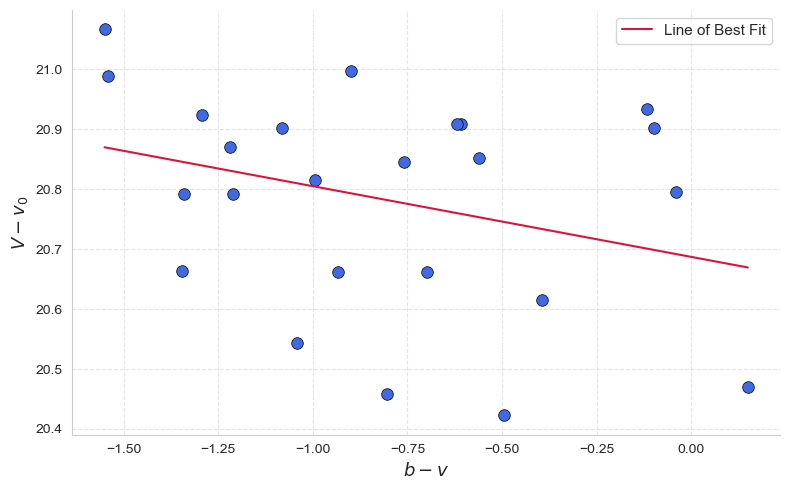

In [11]:
# Apply a clean white Seaborn style
sns.set_style("whitegrid")

# Create figure
plt.figure(figsize=(8, 5))

# Scatter: instrumental color index vs (V - v₀)
sns.scatterplot(
    x=df['B_ins-V_ins'],
    y=df['V-V_ins'],
    edgecolor='black',
    s=70,
    color='royalblue',
    linewidth=0.5
)

# Best-fit line using gamma and beta
x_vals = df['B_ins-V_ins']
y_fit = gamma * x_vals + beta
sns.lineplot(x=x_vals, y=y_fit, color='crimson', label='Line of Best Fit')

# Axis labels
plt.xlabel(r'$b - v$', fontsize=13)
plt.ylabel(r'$V - v_0$', fontsize=13)

# Optional: Add grid and remove top/right borders
plt.grid(True, linestyle='--', alpha=0.5)
sns.despine()

# Add legend and adjust layout
plt.legend(loc='best', fontsize=11)
plt.tight_layout()
plt.show()

In [12]:
# Doing the same for eta and epsilon

df['B-V'] = df['B'] - df['V']

def linear_fit(x, m, c):
    return m * x + c

params, _ = curve_fit(linear_fit, df['B_ins-V_ins'].to_numpy(), df['B-V'].to_numpy())
epsilon, eta = params[0], params[1]

print('Epsilon:\t', epsilon)
print('Eta:\t\t', eta)

Epsilon:	 1.1602652408347853
Eta:		 1.4818180804431966


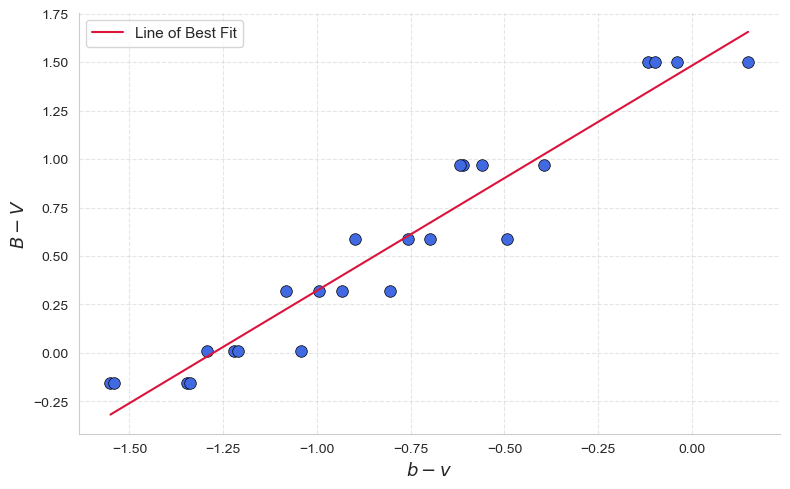

In [13]:
# Apply Seaborn whitegrid style
sns.set_style("whitegrid")

# Create figure
plt.figure(figsize=(8, 5))

# Scatter: instrumental color index (b - v) vs standard color index (B - V)
sns.scatterplot(
    x=df['B_ins-V_ins'],
    y=df['B-V'],
    edgecolor='black',
    s=70,
    color='royalblue',
    linewidth=0.5
)

# Best-fit line using epsilon and eta
x_vals = df['B_ins-V_ins']
y_fit = epsilon * x_vals + eta
sns.lineplot(x=x_vals, y=y_fit, color='crimson', label='Line of Best Fit')

# Axis labels
plt.xlabel(r'$b - v$', fontsize=13)
plt.ylabel(r'$B - V$', fontsize=13)

# Grid and legend
plt.grid(True, linestyle='--', alpha=0.5)
sns.despine()
plt.legend(loc='best', fontsize=11)
plt.tight_layout()
plt.show()

In [14]:
# After fitting for gamma, beta, epsilon, and eta, 
# we can now calculate the standard magnitudes for each star.
df

,star,N_V,N_B,LST,RA_HA,DEC_DMS,V,B,ra_DEG,dec_DEG,cos_Z,X,V_ins,B_ins,V-V_ins,B_ins-V_ins,B-V
0,HR7235,14900000.0,49000000.0,19 29.6,286.352533,13.863477,2.990,3.000,335.288001,13.863477,0.678890,1.470925e+00,-17.932966,-19.225490,20.922966,-1.292525,0.010
1,HR7235,14200000.0,43700000.0,22 18.6,286.352533,13.863477,2.990,3.000,335.288001,13.863477,0.865954,1.154333e+00,-17.880721,-19.101204,20.870721,-1.220483,0.010
2,HR7235,13200000.0,40300000.0,23 10.2,286.352533,13.863477,2.990,3.000,335.288001,13.863477,0.850029,1.175888e+00,-17.801435,-19.013263,20.791435,-1.211828,0.010
3,HR7235,10500000.0,27400000.0,00 09.4,286.352533,13.863477,2.990,3.000,335.288001,13.863477,0.789363,1.265925e+00,-17.552973,-18.594376,20.542973,-1.041403,0.010
4,HR7298,4650000.0,19400000.0,19 32.8,288.439535,39.145966,4.398,4.243,6.593026,39.145966,0.597281,1.670633e+00,-16.668632,-18.219504,21.066632,-1.550872,-0.155
5,HR7298,4330000.0,17900000.0,22 22.0,288.439535,39.145966,4.398,4.243,6.593026,39.145966,0.916278,1.091122e+00,-16.591220,-18.132133,20.989220,-1.540913,-0.155
6,HR7298,3210000.0,11100000.0,23 13.6,288.439535,39.145966,4.398,4.243,6.593026,39.145966,0.968657,1.032276e+00,-16.266263,-17.613307,20.664262,-1.347045,-0.155
7,HR7298,3610000.0,12400000.0,01 15.2,288.439535,39.145966,4.398,4.243,6.593026,39.145966,0.983966,1.016255e+00,-16.393768,-17.733554,20.791768,-1.339786,-0.155
8,HR7377,10400000.0,28200000.0,19 36.0,291.374589,3.114779,3.360,3.680,50.618837,3.114779,-0.284894,inf,-17.542583,-18.625623,20.902583,-1.083039,0.320
9,HR7377,9600000.0,24000000.0,22 25.6,291.374589,3.114779,3.360,3.680,50.618837,3.114779,0.233438,4.194599e+00,-17.455678,-18.450528,20.815678,-0.994850,0.320


In [20]:
# Populating observed reference star magnitudes using the instrumental magnitudes

def return_V_obs(Bins_minus_Vins, V_ins):
    return beta + gamma * Bins_minus_Vins + V_ins

df['V_obs'] = df.apply(lambda row: return_V_obs(row['B_ins-V_ins'], row['V_ins']), axis=1)
df

,star,N_V,N_B,LST,RA_HA,DEC_DMS,V,B,ra_DEG,dec_DEG,cos_Z,X,V_ins,B_ins,V-V_ins,B_ins-V_ins,B-V,V_obs
0,HR7235,14900000.0,49000000.0,19 29.6,286.352533,13.863477,2.990,3.000,335.288001,13.863477,0.678890,1.470925e+00,-17.932966,-19.225490,20.922966,-1.292525,0.010,2.906427
1,HR7235,14200000.0,43700000.0,22 18.6,286.352533,13.863477,2.990,3.000,335.288001,13.863477,0.865954,1.154333e+00,-17.880721,-19.101204,20.870721,-1.220483,0.010,2.950180
2,HR7235,13200000.0,40300000.0,23 10.2,286.352533,13.863477,2.990,3.000,335.288001,13.863477,0.850029,1.175888e+00,-17.801435,-19.013263,20.791435,-1.211828,0.010,3.028446
3,HR7235,10500000.0,27400000.0,00 09.4,286.352533,13.863477,2.990,3.000,335.288001,13.863477,0.789363,1.265925e+00,-17.552973,-18.594376,20.542973,-1.041403,0.010,3.256818
4,HR7298,4650000.0,19400000.0,19 32.8,288.439535,39.145966,4.398,4.243,6.593026,39.145966,0.597281,1.670633e+00,-16.668632,-18.219504,21.066632,-1.550872,-0.155,4.201214
5,HR7298,4330000.0,17900000.0,22 22.0,288.439535,39.145966,4.398,4.243,6.593026,39.145966,0.916278,1.091122e+00,-16.591220,-18.132133,20.989220,-1.540913,-0.155,4.277453
6,HR7298,3210000.0,11100000.0,23 13.6,288.439535,39.145966,4.398,4.243,6.593026,39.145966,0.968657,1.032276e+00,-16.266263,-17.613307,20.664262,-1.347045,-0.155,4.579557
7,HR7298,3610000.0,12400000.0,01 15.2,288.439535,39.145966,4.398,4.243,6.593026,39.145966,0.983966,1.016255e+00,-16.393768,-17.733554,20.791768,-1.339786,-0.155,4.451196
8,HR7377,10400000.0,28200000.0,19 36.0,291.374589,3.114779,3.360,3.680,50.618837,3.114779,-0.284894,inf,-17.542583,-18.625623,20.902583,-1.083039,0.320,3.272116
9,HR7377,9600000.0,24000000.0,22 25.6,291.374589,3.114779,3.360,3.680,50.618837,3.114779,0.233438,4.194599e+00,-17.455678,-18.450528,20.815678,-0.994850,0.320,3.348626


In [16]:
# Select only valid data points:
# - X must be finite, greater than 0, and less than 3 (physically reasonable airmass range)
# - V must be finite (no NaN or inf magnitudes)
valid = np.isfinite(df['X']) & (df['X'] > 0) & (df['X'] < 3) & np.isfinite(df['V'])

# Convert the filtered X and V columns to NumPy arrays for curve fitting
X_clean = df['X'][valid].to_numpy()
V_clean = df['V'][valid].to_numpy()

# Fit extinction coefficient and intercept
params, _ = curve_fit(linear_fit, X_clean, V_clean)
k_V, m = params


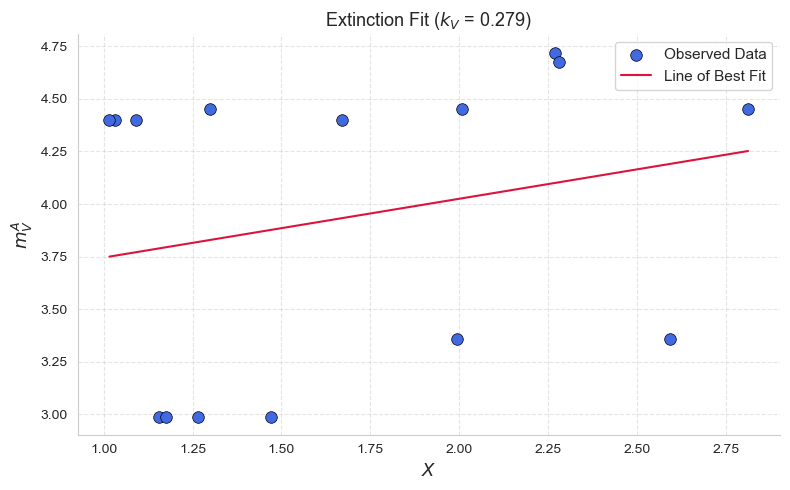

In [17]:
# Apply Seaborn whitegrid style
sns.set_style("whitegrid")

# Create figure
plt.figure(figsize=(8, 5))

# Scatter plot of observed V magnitudes vs airmass
sns.scatterplot(
    x=X_clean,
    y=V_clean,
    edgecolor='black',
    s=70,
    color='royalblue',
    linewidth=0.5,
    label='Observed Data'
)

# Best-fit line (sorted for smooth plotting)
sorted_idx = np.argsort(X_clean)
sns.lineplot(
    x=X_clean[sorted_idx],
    y=(X_clean * k_V + m)[sorted_idx],
    color='crimson',
    label='Line of Best Fit'
)

# Labels and title
plt.xlabel(r'$X$', fontsize=13)              # Airmass
plt.ylabel(r'$m_V^A$', fontsize=13)          # Instrumental V magnitude
plt.title(f'Extinction Fit ($k_V$ = {k_V:.3f})', fontsize=13)
plt.grid(True, linestyle='--', alpha=0.5)
sns.despine()
plt.legend(loc='best', fontsize=11)
plt.tight_layout()
plt.show()

In [18]:
# Using the extinction law to calculate the true V magnitude of our target star
target_V_estimate = gamma * (return_instrument_mag(7.7E5) - return_instrument_mag(3.56E5)) + beta + return_instrument_mag(3.56E5)

print('The estimated true V magnitude of our star is {:.3f}'.format(target_V_estimate))

The estimated true V magnitude of our star is 6.907


In [19]:
# Let's check the target star around its coordinates.

target_table = simbad.query_region(SkyCoord(ra='19h34.1m', dec='+31d18m'), radius=100 * u.arcsec)
target_table

main_id,ra,dec,coo_err_maj,coo_err_min,coo_err_angle,coo_wavelength,coo_bibcode,V,B
,deg,deg,mas,mas,deg,,,,
object,float64,float64,float32,float32,int16,str1,object,float64,float64
Gaia DR3 2044818055433168768,293.5217321563908,31.30481721274166,0.0786,0.0908,90,O,2020yCat.1350....0G,--,--


## Conclusion

Through photometric observations of standard stars using Johnson B and V filters, we determined the atmospheric extinction coefficient in the V band to be approximately $k_V = 0.279 \, \text{mag/airmass}$. This value was obtained from a linear regression between instrumental V magnitudes and computed airmasses, after removing invalid or non-physical data points. The resulting fit showed a clear linear trend, confirming the validity of the extinction correction under stable observing conditions.

We then used the derived color transformation equations to calibrate the brightness of a target star, **Gaia DR3 2044818055433168768**. This object does not have catalogued Johnson UBV magnitudes, but it does have Gaia photometry available. Its Gaia G-band magnitude is approximately 18, which indicates that it is a **very faint and distant** object in the optical band. Despite this, our instrumental observations produced an estimated standard V magnitude of:

$$
V_\text{estimated} = 6.907
$$

This large discrepancy suggests that either the star observed in our setup was incorrectly identified or contaminated by a nearby bright source, or that our transformation does not extrapolate well for faint targets not represented in our standard star sample.

Overall, this experiment demonstrated the importance of atmospheric extinction correction in photometric observations and how calibration using standard stars can be used to estimate unknown magnitudes. The analysis also highlights the need for careful source identification, especially when comparing different photometric systems such as Johnson UBV and Gaia.

## References

- Lang, K. R. (2006). *Astrophysical Formulae*. Springer.
- Karttunen, H., Kröger, P., Oja, H., Poutanen, M., & Donner, K. J. (2007). *Fundamental Astronomy* (5th ed.). Springer.
- Mathar, J. R. (2015). *Astronomical Air Mass*. Retrieved from [http://www.mpia.de/~mathar/public/mathar20151213.pdf](http://www.mpia.de/~mathar/public/mathar20151213.pdf)
- Chromey, F. R. (2010). *To Measure the Sky: An Introduction to Observational Astronomy*. Cambridge University Press.
- Sterken, C., & Manfroid, J. (1992). *Astronomical Photometry: A Guide*. Springer.
- Young, A. T. (1994). *Air mass and refraction*. Applied Optics, 33(6), 1108–1110.
- Bessell, M. S. (2005). *Standard Photometric Systems*. Annual Review of Astronomy and Astrophysics, 43(1), 293–336.
- [SIMBAD Astronomical Database](http://simbad.u-strasbg.fr/simbad/)
- [AstroPy Documentation – Coordinate Transformations](https://docs.astropy.org/en/stable/coordinates/)